# Predicting Company Bankruptcy using Liability Financial Metrics

## Introduction

**Background Information**

The occurrence of bankruptcies that are linked to business failures is becoming a common concern for many companies and their stakeholders. They can occur through the natural course of progression (such as smartphone cameras replacing the non-professional dedicated camera market), or be exacerbated through exogenous shocks (such as the dot-com bubble of 2001, or the 2007 financial crisis).  

**Predictive Question**

In this analysis, we will determine **if we can predict the looming bankruptcy of a company based on a variety of fundamental financial metrics, specifically related to debt and liabilities**. Moreover, we will be looking at metrics that may indicate an imminent bankruptcy as opposed to a drawn-out downfall.

**Dataset**

We will use the Taiwanese Bankruptcy Prediction dataset from the Taiwan Economic Journal (TEJ), spanning from 1999-2009. Since its 1990 inception, the TEJ has focused on delivering essential financial market data [1]. Within this 1999-2000 period, the TEJ recorded 220 observations of bankruptcy within the total 6,819 observations they collected data on. Company bankruptcy was defined based on the business rules of the Taiwan Stock Exchange [2].

The dataset includes 95 columns of financial metrics, and a 96th column for a bankruptcy flag (yes/no).
We will use the bankruptcy flag as our classification variable.

[1] https://www.tejwin.com/en/about/

[2] Lyon,Robert. (2017). HTRU2. UCI Machine Learning Repository. https://doi.org/10.24432/C5DK6R.
#TO CHANGE TO REFERENCE SECTION

# Methods & Results

The process will start by reading necessary libraries:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)

install.packages("psych") #this is loaded to obtain a basic description of the data set
library(psych) 
install.packages("themis") #this is loaded to for the step_upsample funciton used in the recipe
library(themis)

options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

To read the data, we will need to:
1) Download the zip file from its source [2] above
2) Specify where to save the zip file
3) Unzip the file to our desired location

In [2]:
# Set an initial seed so analysis does not change between instances of reloading the file
set.seed(7834) 

#get file, which is stored as a .zip
url <- "https://archive.ics.uci.edu/static/public/572/taiwanese+bankruptcy+prediction.zip"
data_directory <- "data/"

dir.create(file.path(dirname(data_directory), "data")) #create the directory to save the file

zip_file_name <- "data.zip"
download.file(url, paste(data_directory, zip_file_name, sep=""), mode = "wb") #download file
#unzip the zipfile
unzip(paste(data_directory, zip_file_name, sep=""),exdir=data_directory) #unzip the data

Warning message in dir.create(file.path(dirname(data_directory), "data")):
“'./data' already exists”


In [3]:
taiwan_data <- read_csv("data/data.csv") |>
               clean_names(replace = c('/' = " over ", '%' = "percent")) #the headers have numerous spaces and/or invalid characters.  But we we want to preserve % as "percent", and / as "over".



Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): Bankrupt?, ROA(C) before interest and depreciation before interest...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The data set is quite clean:
- The prediction column, bankrupt, contained either a 0 or 1, indicating if the company is bankrupt (1) or not (0).
- No  invalid data (ie., factors in a double column)
- No  missing data (ie., no blank or NA)

However, it is also highly imbalanced. Of the 6,819 observations, only 220 are labeled bankrupt, which represents approximately 3.23% of the observations. 

In the process of tidying, we made the following adjustments:
 1) Clean the headers of our data as numerous of them have spaces and/or invalid characters (such as "?" or "/")
 2) Change our classification column, "bankrupt", to a factor, and rename the 1 and 0 by their respective human definitions (1 = Bankrupt, 0 = Not Bankrupt).  This is what we are going to be predicting.
 3) Select the columns necessary for the analysis.  As we are looking to determine the bankruptcy of a company based on a subset of debt and liability metrics, we will initially filter the data for columns containing the word "debt", and columns containing any form of the word "liability."
 4) Remove preliminary columns that fall within the selection but do not have relevant data for us, namely: interest_bearing_debt_interest_rate and liability_assets_flag
 5) Mutated the debt_ratio_percent column via multiplication of 100 to provide a more human-understandable value for the category, which is a percentage

In [4]:
taiwan_preliminary <- taiwan_data |>
                mutate(bankrupt = fct_recode(factor(bankrupt), "Bankrupt" = '1', "Not Bankrupt" = '0'), debt_ratio_percent = debt_ratio_percent * 100) |> #change numerical values to factors/classifications.
                select(bankrupt, contains("debt"), contains("liabilit")) |>  #select 1) classification column (bankrupt), 2) columns containing "Debt", and 3) columns containing any form of liability
                select(!c(interest_bearing_debt_interest_rate, liability_assets_flag)) #remove two additional columns - interest rate, and liability asset flag.

taiwan_preliminary
describe(taiwan_preliminary, IQR = 0) #high-level overview of our preliminary data


bankrupt,total_debt_over_total_net_worth,debt_ratio_percent,contingent_liabilities_over_net_worth,quick_assets_over_current_liability,cash_over_current_liability,current_liability_to_assets,operating_funds_to_liability,inventory_over_current_liability,current_liabilities_over_liability,current_liabilities_over_equity,long_term_liability_to_current_assets,current_liability_to_liability,current_liability_to_equity,equity_to_long_term_liability,cash_flow_to_liability,current_liability_to_current_assets,liability_to_equity,equity_to_liability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bankrupt,0.02126592,20.75763,0.006478502,0.001996771,1.47336e-04,0.14730845,0.3340152,0.001035990,0.6762692,0.3390770,0.025592368,0.6762692,0.3390770,0.1265495,0.4586091,0.11825048,0.2902019,0.01646874
Bankrupt,0.01250239,17.11763,0.005835039,0.004136030,1.38391e-03,0.05696283,0.3411060,0.005209682,0.3085886,0.3297401,0.023946819,0.3085886,0.3297401,0.1209161,0.4590011,0.04777528,0.2838460,0.02079431
Bankrupt,0.02124769,20.75158,0.006561982,0.006302481,5.34000e+09,0.09816206,0.3367315,0.013878786,0.4460275,0.3347769,0.003715116,0.4460275,0.3347769,0.1179223,0.4592540,0.02534649,0.2901885,0.01647411
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Not Bankrupt,0.0013915866,3.893944,0.005365848,0.035531293,0.088212480,0.02441366,0.3588474,0.007809807,0.5539642,0.3269206,0.0e+00,0.5539642,0.3269206,0.1109332,0.4524647,0.007542458,0.2757887,0.09764874
Not Bankrupt,0.0038163762,8.697887,0.007067734,0.007753306,0.007133218,0.08319943,0.3802508,0.013333639,0.8932409,0.3292936,3.2e+09,0.8932409,0.3292936,0.1109574,0.4713133,0.022916427,0.2775472,0.04400945
Not Bankrupt,0.0004614304,1.414880,0.006368212,0.051480515,0.066673545,0.01851735,0.2395847,0.000000000,1.0000000,0.3266903,0.0e+00,1.0000000,0.3266903,0.1109332,0.4832848,0.005579107,0.2751141,0.23390224


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bankrupt*,1,6819,1.032263e+00,1.767102e-01,1.000000000,1.000000000,0.000000000,1,2.00e+00,1.00e+00,5.2930581,26.02028,2.139938e-03
total_debt_over_total_net_worth,2,6819,4.416337e+06,1.684069e+08,0.005546284,0.006182498,0.004342654,0,9.94e+09,9.94e+09,46.3349439,2345.82888,2.039387e+06
debt_ratio_percent,3,6819,1.131771e+01,5.392031e+00,11.140671766,11.142242947,5.638693957,0,1.00e+02,1.00e+02,0.9803647,10.71696,6.529682e-02
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
current_liability_to_current_assets,17,6819,0.03150637,0.03084469,0.02759714,0.02815979,0.014960856,0,1,1,13.182859,310.67834,0.0003735253
liability_to_equity,18,6819,0.28036515,0.01446322,0.27877758,0.27923474,0.003132165,0,1,1,27.447388,1207.96090,0.0001751478
equity_to_liability,19,6819,0.04757836,0.05001372,0.03379770,0.03864914,0.017154643,0,1,1,7.397845,93.96788,0.0006056598


The initial tiding and wrangling narrowed down the financial metrics to those which include debt and/or liabilities to 19 columns. Within that 19, we have the following:

- **Bankruptcy Flag (Y/N)**
- Total debt over total net worth
- **Debt ratio (as a percentage)**
- Contingent liabilities over net worth
- **Quick assets over current liability**
- Cash over current liability
- Current liability to assets
- Operating funds to liability
- Inventory over current liability
- **Current liabilities over liability**
- ~~Current liabilities over equity~~
- Long term liability to current assets
- ~~Current liability to liability~~
- Current liability to equity
- Equity to long-term liability
- Cash flow to liability
- Current Liability to current assets
- Liability to equity
- ~~Equity to liability~~

That said, we noticed something strange when data wrangling. Some of the categories had identical values but with similar (yet still unique) names. For instance: current_liabilities_over_liability shared identical data with current_liability_to_liability.  We ultimately determined the categories were oriented in such a way so that other data scientists, who may be looking specifically for "current liabilities" vs "current liability" can use those columns.  

To preserve the quality and integrity of our analysis, we will not be using the duplicated or reciprocal categories.  They are represented by the strikethrough.

In [5]:
# Removing the three specified variables to preserver integrity
taiwan_integrity <- taiwan_preliminary |>
               select(-current_liability_to_liability, -current_liabilities_over_equity, -equity_to_liability) 
taiwan_integrity

bankrupt,total_debt_over_total_net_worth,debt_ratio_percent,contingent_liabilities_over_net_worth,quick_assets_over_current_liability,cash_over_current_liability,current_liability_to_assets,operating_funds_to_liability,inventory_over_current_liability,current_liabilities_over_liability,long_term_liability_to_current_assets,current_liability_to_equity,equity_to_long_term_liability,cash_flow_to_liability,current_liability_to_current_assets,liability_to_equity
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bankrupt,0.02126592,20.75763,0.006478502,0.001996771,1.47336e-04,0.14730845,0.3340152,0.001035990,0.6762692,0.025592368,0.3390770,0.1265495,0.4586091,0.11825048,0.2902019
Bankrupt,0.01250239,17.11763,0.005835039,0.004136030,1.38391e-03,0.05696283,0.3411060,0.005209682,0.3085886,0.023946819,0.3297401,0.1209161,0.4590011,0.04777528,0.2838460
Bankrupt,0.02124769,20.75158,0.006561982,0.006302481,5.34000e+09,0.09816206,0.3367315,0.013878786,0.4460275,0.003715116,0.3347769,0.1179223,0.4592540,0.02534649,0.2901885
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Not Bankrupt,0.0013915866,3.893944,0.005365848,0.035531293,0.088212480,0.02441366,0.3588474,0.007809807,0.5539642,0.0e+00,0.3269206,0.1109332,0.4524647,0.007542458,0.2757887
Not Bankrupt,0.0038163762,8.697887,0.007067734,0.007753306,0.007133218,0.08319943,0.3802508,0.013333639,0.8932409,3.2e+09,0.3292936,0.1109574,0.4713133,0.022916427,0.2775472
Not Bankrupt,0.0004614304,1.414880,0.006368212,0.051480515,0.066673545,0.01851735,0.2395847,0.000000000,1.0000000,0.0e+00,0.3266903,0.1109332,0.4832848,0.005579107,0.2751141


In spot-checking our data, we noticed three observations did not make sense as they had quick ratios exceeding over 1,000,000,000.  Generally speaking, a quick ratio should remain at or around 1.  It may also fall below 1 in numerous circumstances,  such as if the company were to have strong terms with their lenders or if they were using debt financing (https://www.theforage.com/blog/skills/quick-ratio).

We filtered out the observations where quick_assets_over_current_liability exceeded 1.0 as they had the capability to greatly skew the data in inappropriate ways.  This leaves us with 6,816 observations.

In [6]:
# Spot check quick_assets_over_quick_Liability and make integrity adjustments
head(arrange(taiwan_integrity, -quick_assets_over_current_liability), n = 6)

taiwan_tidy <- taiwan_integrity |>
                filter(quick_assets_over_current_liability <= 1)

bankrupt,total_debt_over_total_net_worth,debt_ratio_percent,contingent_liabilities_over_net_worth,quick_assets_over_current_liability,cash_over_current_liability,current_liability_to_assets,operating_funds_to_liability,inventory_over_current_liability,current_liabilities_over_liability,long_term_liability_to_current_assets,current_liability_to_equity,equity_to_long_term_liability,cash_flow_to_liability,current_liability_to_current_assets,liability_to_equity
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Not Bankrupt,1.877183e-02,19.9534420,0.005505387,8.820000e+09,0.0001692919,0.207914962,0.3330251,0.0194501073,0.998851283,4.96e+08,0.3428850,0.1109452,0.4595297,0.0387014810,0.2883929
Not Bankrupt,8.266535e-03,14.0550836,0.005378035,8.140000e+09,0.0005556540,0.147365330,0.3462310,0.0289934308,0.996929132,0.00e+00,0.3335787,0.1109332,0.4602588,0.0261608590,0.2807740
Not Bankrupt,1.945349e-01,31.2755087,0.005365848,7.540000e+09,0.0005159688,0.323917383,0.3361380,0.0001647657,0.999816524,0.00e+00,0.1538113,0.1109332,0.4598050,1.0000000000,0.1335029
Not Bankrupt,4.740000e+08,0.1511624,0.006179317,1.000000e+00,0.0100617624,0.000000000,0.2312676,0.0000000000,0.063817399,0.00e+00,0.3261745,0.1109332,0.3438437,0.0000000000,0.2748133
Not Bankrupt,0.000000e+00,0.0000000,0.005365848,3.251893e-01,1.0000000000,0.001481325,0.7085025,1.0000000000,0.425415889,0.00e+00,0.3262137,0.1109332,0.8131231,0.0001224443,0.2747791
Not Bankrupt,2.237846e-03,5.7985912,0.005365848,2.750005e-01,0.7381063010,0.001043267,0.3488339,0.0198437362,0.007776519,0.00e+00,0.3262119,0.1109332,0.4665655,0.0007703564,0.2764018


Following the data wrangling and tidying, we separated our data into respective training and testing groups.  We used a proportion of 75% for separating the data, using our prediction column, bankrupt, as the strata.

In [7]:
# We will separate our data into respective training and testing groups.
taiwan_initial_split <- initial_split(taiwan_tidy, prop = 0.75, strata = bankrupt)
taiwan_initial_training <- training(taiwan_initial_split)
taiwan_initial_testing <- testing(taiwan_initial_split)

A summary of the split is found below.

In [8]:
# Set an initial seed so analysis does not change between instances of reloading the file
set.seed(7834) 
taiwan_training_count <- taiwan_initial_training |>
                                          group_by(bankrupt) |>
                                          summarize(observations_training = n())
taiwan_testing_count <- taiwan_initial_testing |>
                                          group_by(bankrupt) |>
                                          summarize(observations_testing = n())
taiwan_training_count
taiwan_testing_count 

bankrupt,observations_training
<fct>,<int>
Not Bankrupt,4947
Bankrupt,165


bankrupt,observations_testing
<fct>,<int>
Not Bankrupt,1649
Bankrupt,55


### Preliminary Analysis

We will use four key variables for our preliminary analysis to provide an idea of the validity of our thesis:
- **Bankruptcy Flag:** our predictor variable.
- **Debt ratio (as a percentage):** represents the amount of leverage used by a company in terms of total debt to total assets. (https://www.investopedia.com/terms/d/debtratio.asp)
- **Quick assets over current liability:** also known as the "quick ratio", represents the extent to which a business can pay its short-term obligations with its most liquid assets, not including inventory. (https://www.netsuite.com/portal/resource/articles/financial-management/quick-ratio.shtml)
- **Current liabilities over liability:** represents the proportion of all liabilities which are due within the next 12 months to the total amount of liabilities (https://www.bdc.ca/en/articles-tools/entrepreneur-toolkit/templates-business-guides/glossary/current-liabilities

The _quick ratio_ will give us an idea of the company's ability to settle short-term obligations, while _current liability to liability_ will provide an outline of which portion of the company's total obligations will become due within the next 12 months.  Finally, the _debt ratio_ outlines how much of the company is made up of debt.

In [9]:
taiwan_preliminary <- taiwan_initial_training |>
                select(bankrupt, debt_ratio_percent, quick_assets_over_current_liability, current_liabilities_over_liability)
taiwan_preliminary

bankrupt,debt_ratio_percent,quick_assets_over_current_liability,current_liabilities_over_liability
<fct>,<dbl>,<dbl>,<dbl>
Bankrupt,20.75763,0.001996771,0.6762692
Bankrupt,17.11763,0.004136030,0.3085886
Bankrupt,20.75158,0.006302481,0.4460275
⋮,⋮,⋮,⋮
Not Bankrupt,3.893944,0.035531293,0.5539642
Not Bankrupt,8.697887,0.007753306,0.8932409
Not Bankrupt,1.414880,0.051480515,1.0000000


Three new dataframes to aid in the visualization and summarization of our data, using the four key variables from taiwan_preliminary as the basis.

In [10]:
# This creates a new dataframe for the purposes of organizing the columns to better fit our intended visualizations.
taiwan_viz <- taiwan_preliminary |>
              pivot_longer(cols = -bankrupt, names_to = 'category', values_to ='value') 

# This creates a new dataframe to group the data by bankrupt and a respective mean value for each column.
taiwan_preliminary_all_mean_summary <- taiwan_preliminary |>
                                          group_by(bankrupt) |>
                                          summarize_all(mean)

# This creates a new dataframe for the purposes of highlighting the mean value of the taiwan_viz dataframe and to add labels to the graph.
taiwan_viz_mean <- taiwan_preliminary_all_mean_summary |>
              pivot_longer(cols = -bankrupt, names_to = 'category', values_to ='value_mean') |>
              mutate(x = c(6, 0.03, 0.45, 32, 0.003, 0.45), y = c(3, 1, 4.5, 3.5, 1.3, 4))

Commentary on summarizing the data set which is relevant for exploratory data analysis related to the planned analysis


We opted to use a density plot to visualize the distribution of our numeric variables. It allows us to contrast the ranges of differences between bankrupt and not-bankrupt companies.  

Given our variables resolve to ratios, we determined scaling the x-axis logarithmically provided the most clear depiction of ranges.  Finally, we highlighted the average for each variable based on bankruptcy status.

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”


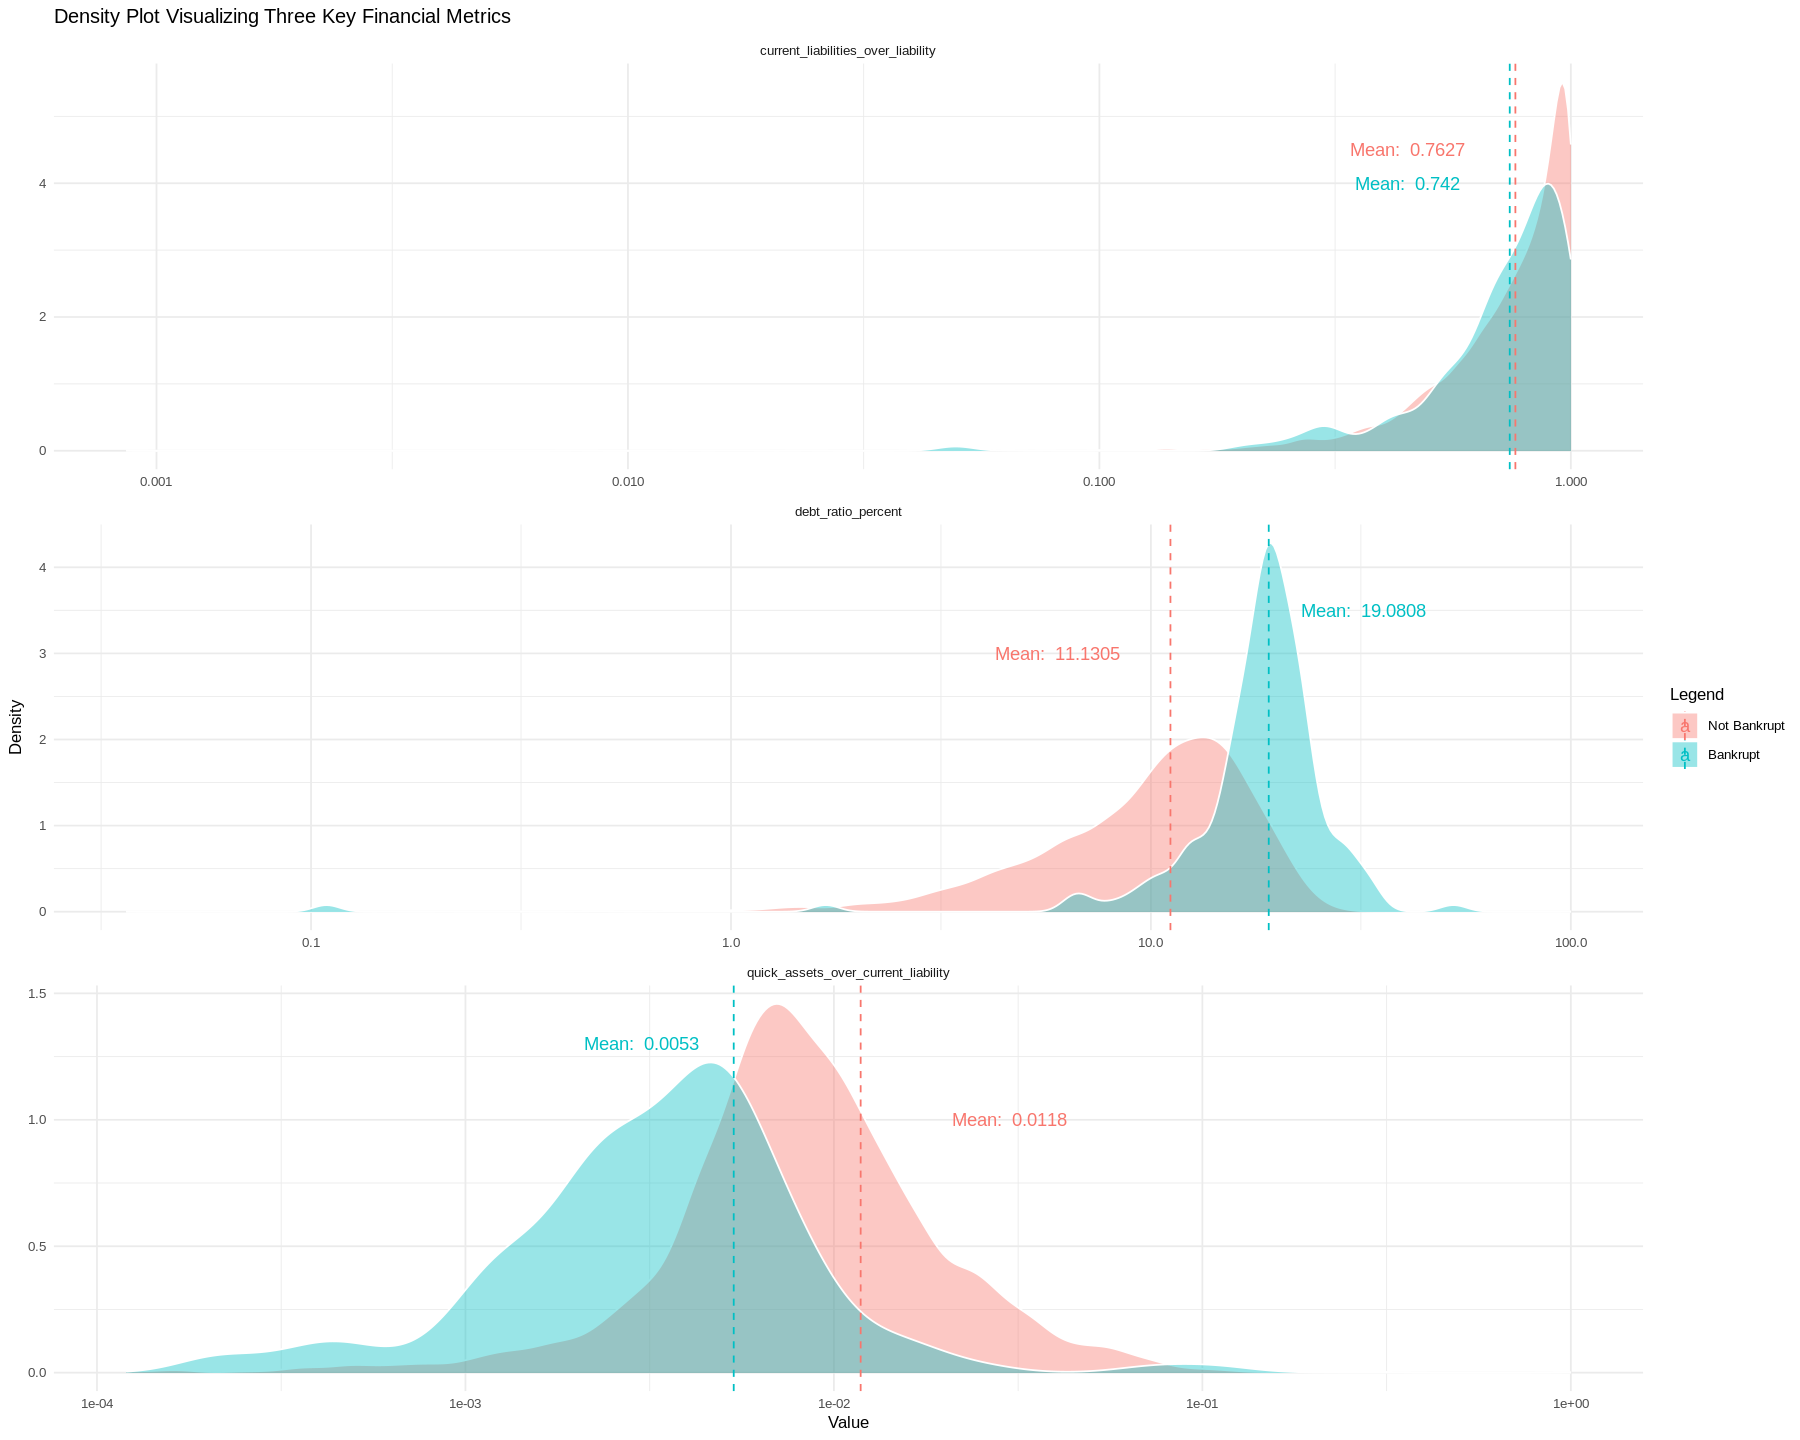

In [11]:
options(repr.plot.height = 12, repr.plot.width = 15)

taiwan_plot_2 <- taiwan_viz |> 
                    ggplot(aes(value, fill = bankrupt)) +
                    geom_density(alpha = 0.4, colour = 'white') +
                    facet_wrap(vars(category), nrow = 3, scales = 'free') +
                    theme_minimal() +
                    scale_x_log10() + #we scale the X axis, as all categories observe a large range in their values
                    geom_vline(data = taiwan_viz_mean, aes (xintercept=value_mean, color=bankrupt), linetype="dashed") +
                    geom_text(data = taiwan_viz_mean, aes(label = paste("Mean: ", round(value_mean,4)), x = x, y = y,  colour = bankrupt)) +
                    labs(x = "Value", y = "Density", title = "Density Plot Visualizing Three Key Financial Metrics", colour = "Legend", fill = "Legend") +
                    theme(text = element_text(size = 10))

taiwan_plot_2

The visualization agrees strongly with our thesis. It showed that bankrupt companies are more likely to have a higher amount of debt and that non-bankrupt companies generally have a higher level of quick assets to cover short-term obligations and expenses. 

Interestingly, the ratio of current liabilities over liabilities did not differ between the two by an appreciable amount.

# Data Analysis

As a result of the significant imbalance between bankrupt vs not bankrupt observations, we incorporated the step_upsample function to replicate rows of our data set to make the occurence of observations equal for both bankrupt and not bankrupt.  Then, we scaled and centered the data to remove any weighting bias of any one factor.

In [12]:
taiwan_recipe <- recipe(bankrupt ~ . , data = taiwan_initial_training) |>
                step_upsample(bankrupt) |> #replicates rows in the dataset to make the observations for both bankrupt and not bankrupt equal.
                step_scale(all_predictors()) |>
                step_center(all_predictors()) 

taiwan_scaled <- taiwan_recipe |>  
                     prep() |> 
                     bake(taiwan_initial_training)

taiwan_scaled

total_debt_over_total_net_worth,debt_ratio_percent,contingent_liabilities_over_net_worth,quick_assets_over_current_liability,cash_over_current_liability,current_liability_to_assets,operating_funds_to_liability,inventory_over_current_liability,current_liabilities_over_liability,long_term_liability_to_current_assets,current_liability_to_equity,equity_to_long_term_liability,cash_flow_to_liability,current_liability_to_current_assets,liability_to_equity,bankrupt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.05721859,0.8310596,-0.03887893,-0.4035097,-0.1452712,0.4534711,-0.3730336,-0.1039637,-0.3742133,-0.1064157,0.03822150,0.05310456,0.01074419,1.56826666,0.05933255,Bankrupt
-0.05721859,0.2943146,-0.05202174,-0.2709650,-0.1452712,-0.9914907,-0.1627427,-0.1039637,-2.1555614,-0.1064157,-0.15439539,-0.03940319,0.02321846,0.02732354,-0.06437979,Bankrupt
-0.05721859,0.8301680,-0.03717384,-0.1367354,6.8351043,-0.3325620,-0.2924762,-0.1039637,-1.4896940,-0.1064157,-0.05048955,-0.08856522,0.03127082,-0.46308296,0.05907252,Bankrupt
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.05721859,-1.6556211,-0.06160503,1.67423056,-0.1452712,-1.5120726,0.3634120,-0.1039637,-0.9667593,-0.1064157,-0.2125619,-0.2033355,-0.1848328,-0.8523688,-0.2212086,Not Bankrupt
-0.05721859,-0.9472425,-0.02684379,-0.04684488,-0.1452712,-0.5718701,0.9981655,-0.1039637,0.6769769,4.7996348,-0.1636078,-0.2029385,0.4151159,-0.5162164,-0.1869806,Not Bankrupt
-0.05721859,-2.0211783,-0.04113162,2.66241640,-0.1452712,-1.6063764,-3.1735375,-0.1039637,1.1942059,-0.1064157,-0.2173136,-0.2033355,0.7961633,-0.8952976,-0.2343388,Not Bankrupt


### Fine Tuning

To train and test the model, we used VFold as the cross-validator. 

In [13]:
# Set an initial seed so analysis does not change between instances of reloading the file
set.seed(7834) 

# Specify the vfold with v folds, using our classifier bankrupt as the strata
taiwan_vfold <- vfold_cv(taiwan_initial_training, v = 5, strata = bankrupt)

# Specify tune() for the neighbours to determine the most accurate value
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

knn_results <- workflow() |>
       add_recipe(taiwan_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = taiwan_vfold, grid = 10) |>
       collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9452248,5,0.00385896,Preprocessor1_Model01
3,accuracy,binary,0.9256630,5,0.00480072,Preprocessor1_Model02
4,accuracy,binary,0.9256630,5,0.00480072,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.8718676,5,0.003326505,Preprocessor1_Model08
13,accuracy,binary,0.8609139,5,0.001994172,Preprocessor1_Model09
14,accuracy,binary,0.8609139,5,0.001994172,Preprocessor1_Model10


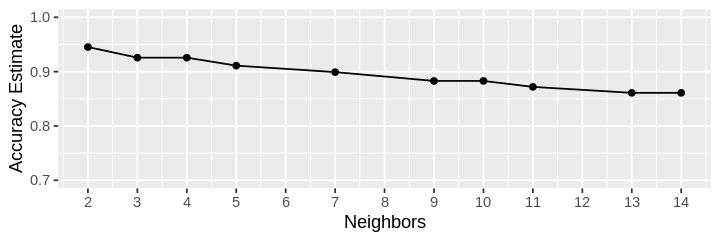

In [14]:
options(repr.plot.height = 2, repr.plot.width = 6)

accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 15, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.7, 1.0)) # adjusting the y-axis
accuracy_versus_k

### Predicting the Data

Following the fine tuning, we chose with K=3 neighbours as we wanted to remove any ties which could be brought about with the even number K=2 and use the training data to train our model.

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
       set_engine("kknn") |>
       set_mode("classification")

taiwan_fit <- workflow() |>
       add_recipe(taiwan_recipe) |>
       add_model(knn_spec) |>
       fit(data = taiwan_initial_training)

taiwan_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_upsample()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02567212
Best kernel: rectangular
Best k: 3

After our model is trained, we use the testing data to predict the bankruptcy status.

In [22]:
taiwan_test_predictions <- predict (taiwan_fit, taiwan_initial_testing) |>
                            bind_cols(taiwan_initial_testing)

taiwan_conf_mat <- taiwan_test_predictions |>
                  conf_mat(truth = bankrupt, estimate = .pred_class)

taiwan_conf_mat

              Truth
Prediction     Not Bankrupt Bankrupt
  Not Bankrupt         1569       37
  Bankrupt               80       18

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.9769614
recall,binary,0.9514857
accuracy,binary,0.9313380
kap,binary,0.2023110


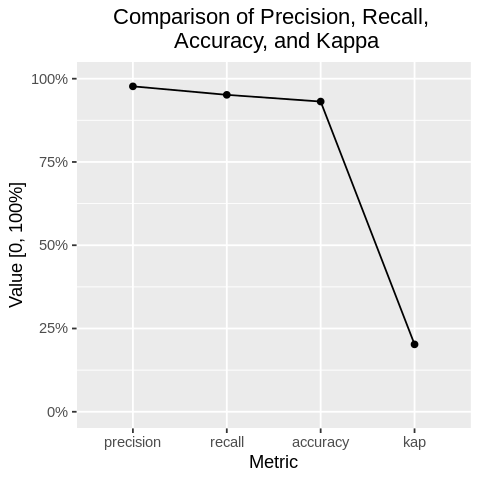

In [44]:
options(repr.plot.height = 4, repr.plot.width = 4)

# Analyze the accuracy, recall, and precision of the model, including its kappa to measure inter-rater reliability.
taiwan_prediction_accuracy <- taiwan_test_predictions |>
                             metrics(truth = bankrupt, estimate = .pred_class)
taiwan_prediction_recall <- taiwan_test_predictions |>
                             recall(truth = bankrupt, estimate = .pred_class)
taiwan_prediction_precision <- taiwan_test_predictions |>
                             precision(truth = bankrupt, estimate = .pred_class)

taiwan_prediction_metrics <- taiwan_prediction_accuracy |>
                             bind_rows(taiwan_prediction_recall) |>
                             bind_rows(taiwan_prediction_precision) |>
                             arrange(-.estimate)

# Create a plot of the analysis
taiwan_prediction_metrics_plot <- taiwan_prediction_metrics |>
                                  ggplot(aes(x=reorder(.metric, -.estimate), y=.estimate)) +
                                  geom_point() +
                                  geom_line(group = "identity") +
                                  scale_y_continuous(labels = scales::percent_format(), limits = c(0,1)) +
                                  labs(x="Metric", y="Value [0, 100%]", title="Comparison of Precision, Recall, \n Accuracy, and Kappa") +
                                  theme(plot.title = element_text(hjust = 0.5))


taiwan_prediction_metrics
taiwan_prediction_metrics_plot

# Discussion

Our model looks promising at a first glance, with the following characteristics:
- Accuracy: 93.1%
- Recall: 95.1%
- Precision: 97.7%

Overall, the accuracy of our model had a strong capability to correctly predicted the bankrupt/not bankrupt status of a particular testing observation, relative to all testing observations. Furthermore, the model's recall shows if there is a positive observation in our testing data, the model will find it, relative to all testing observations.  And lastly, the precision characteristic was the strongest of them all in its ability to predict the correct number of position predictions, relative to the total number of positive predictions in the testing set.

However, diving in deeper we see that the Kappa is only 20.2%. The inter-rater reliability is exceptionally low.  It's suggested that "the Kappa result be interpreted as follows: values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/#:~:text=Cohen%20suggested%20the%20Kappa%20result,1.00%20as%20almost%20perfect%20agreement. Our Kappa then indicates there is essentially zero agreement, and that the model in fact does not perform a satisfactory job in predicting if a company will become bankrupt.

Plotting the confusion matrix, it makes sense that our Kappa is low:

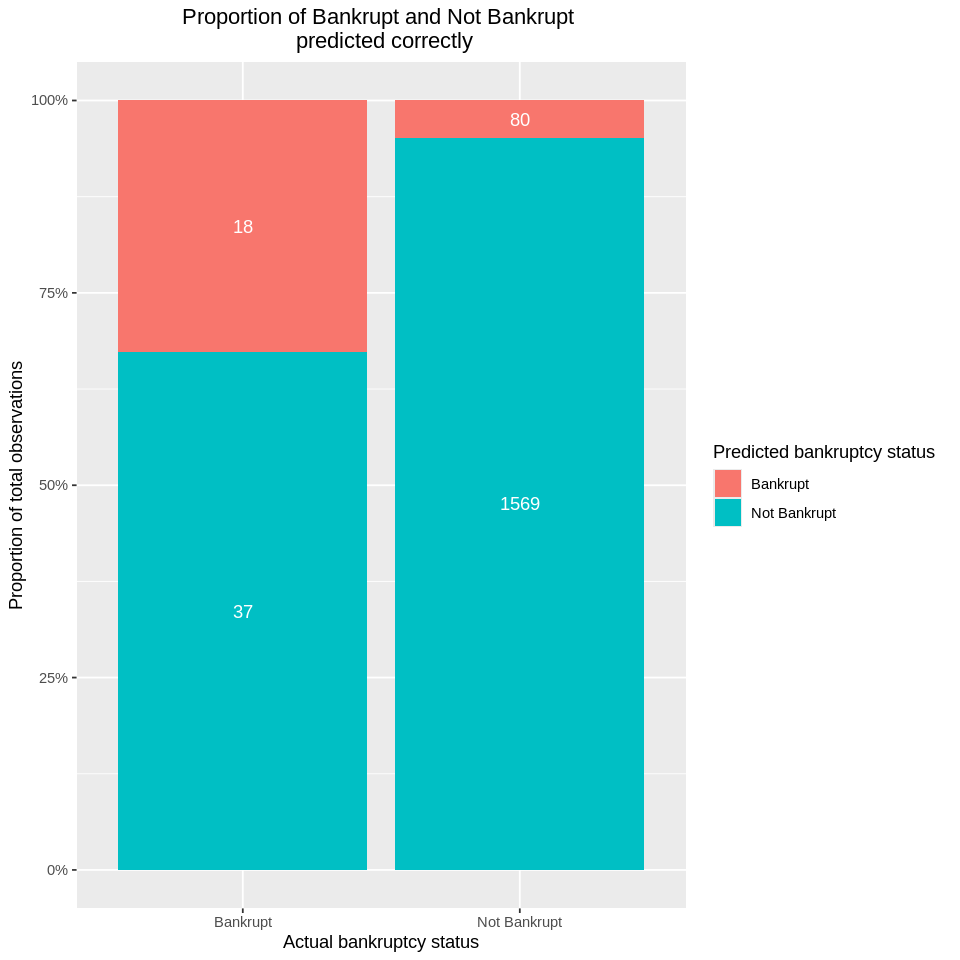

In [21]:
options(repr.plot.height = 8, repr.plot.width = 8)

# Recreate the confusion matrix in a form we can mapipulate for a ggplot graphic
predictor <- c("Not Bankrupt", "Bankrupt")
not_bankrupt <- c(sum(taiwan_test_predictions$.pred_class == "Not Bankrupt" & taiwan_test_predictions$bankrupt == "Not Bankrupt"), sum(taiwan_test_predictions$.pred_class == "Bankrupt" & taiwan_test_predictions$bankrupt == "Not Bankrupt"))
bankrupt <- c(sum(taiwan_test_predictions$.pred_class == "Not Bankrupt" & taiwan_test_predictions$bankrupt == "Bankrupt"), sum(taiwan_test_predictions$.pred_class == "Bankrupt" & taiwan_test_predictions$bankrupt == "Bankrupt"))

# Configure the dataframe in a way to be utilized by ggplot
conf <- data.frame(predictor, not_bankrupt, bankrupt) |>
        pivot_longer(c(not_bankrupt, bankrupt), names_to = "actual", values_to = "values") |>
        mutate(actual = fct_recode(actual, "Bankrupt" = 'bankrupt', "Not Bankrupt" = 'not_bankrupt')) #change numerical values to factors/classifications.



# Plot the confusion matrix, showing which % was correctly predicted
conf_bar_plot <- conf |>
                    ggplot(aes(x=actual, y = values, fill = predictor)) +
                    geom_bar(stat = "identity", position = "fill") +
                    scale_y_continuous(labels = scales::percent_format()) +
                    labs(x = "Actual bankruptcy status", fill = "Predicted bankruptcy status", y = "Proportion of total observations", title = "Proportion of Bankrupt and Not Bankrupt \n predicted correctly") +
                    geom_text(aes(label = values), colour = "white", position = position_fill(vjust = 0.5)) +
                    theme(plot.title = element_text(hjust = 0.5))
conf_bar_plot 

Although the model correctly predicted Not Bankrupt 1,569 out of 1,649 times (95.1%), it only predicted Bankrupt 18 out of 55 times (32.7%). Given the promising preliminary analysis, accuracy, precision, and recall, this is not what we expected.

However upon reflection, we think this makes sense for a number of reasons:
1) **Between the years of collection (1999-2009) there were two exogenous shocks:** the 2001 dot-com bubble, and the 2007 financial crisis.  Given the data lacks an indicator of year, it is not known how either of those shocks effected the data (if at all).  It is possible the sudden onset of those shocks caused the firms to fail before they published their next-quarter results, which then would not be captured in the data.
2) **There is no indication of industry or sector.** A firm in the technology sector, for instance, may best be analyzed by its ability to cover liabilities (https://www.investopedia.com/articles/active-trading/082615/key-financial-ratios-analyze-tech-companies.asp), while a grocery store could best be analyzed in its ability to turnover inventory and increase profit margins (https://www.investopedia.com/ask/answers/060515/what-are-some-important-financial-ratios-evaluate-respect-consumer-packaged-goods.asp).
3) **The data is heavily skewed:** only 220 of the 6,819 observations were Bankrupt.  Even with upsampling, there just is not enough variation in the source data to provide a compelling analysis.

Nevertheless, the findings from the analysis could have several impacts on companies. From the preliminary analysis, it is clear that there is a linkage between the amount of debt a company has (its debt ratio), and its ability to service ongoing liabilities (quick ratio).  

Although futher refinement is likely required as outlined in the 3 points above, companies could use this insight to proactively manage their risks of bankruptcy, by identifying early bankruptcy warning signs and implementing strategies to address any financial instability. Likewise, Banks can use the findings to enhance their credit assessments, when lending out loans they can use the bankruptcy models to predict bankruptcy for their credit borrowers and reduce the likelihood of any defaults.   

Future questions from this finding could include: how effective are traditional financial metrics in predicting bankruptcy relative to any other type or sources of data, or what is the quantifiable extent of the year and/or industry of each observation?

# References

MLA or APA